In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/tmp/ipykernel_335046/3202773982.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Catalogues of clusters and photon lists:

In [2]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [3]:
clusters_31 = clusters[clusters["M500"]>1.54e+14]#.index
len(clusters_31)

31

In [4]:
max(clusters["M500"])
sorted_df = clusters.sort_values(by='M500', ascending=True)
pp = sorted_df[-10:] #.index.to_numpy()
pp

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0
17415,12,0.894367,0.744828,0.824320,0.010582,6.199650e+14,0.113899,0.114416,2.546730e+14,812.334,8.472320e+12,2.390040e+13,4.29270,1.97013,0.000006,3.893800e+14,1270.13,0
7364,40,0.162694,0.424409,0.819369,0.005600,4.108630e+14,0.187590,0.187651,2.629270e+14,855.796,7.645220e+12,2.548580e+13,3.62390,1.93123,0.000006,3.565690e+14,1285.57,0
6529,28,0.092511,0.467734,0.720542,0.005870,4.731190e+14,0.183842,0.183891,2.829050e+14,876.916,8.308680e+12,3.100020e+13,4.02647,2.50744,0.000007,4.143840e+14,1351.69,0
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
1819,3,0.204613,0.565107,0.195564,0.006714,7.078500e+14,0.164042,0.164255,3.324680e+14,925.414,8.535330e+12,3.912870e+13,4.46750,3.58050,0.000009,5.451040e+14,1480.97,0
6695,20,0.754882,0.767027,0.737996,0.006361,6.020500e+14,0.184504,0.183999,3.326050e+14,925.525,9.334830e+12,3.543870e+13,4.69222,3.75467,0.000009,4.836230e+14,1423.10,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2270,5,0.132094,0.683505,0.238968,0.007008,8.050390e+14,0.165672,0.165388,4.841240e+14,1048.910,1.277250e+13,5.734860e+13,6.00627,25.09790,0.000014,6.741010e+14,1589.63,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0


#### Stacked image of all slices in the lightcone:

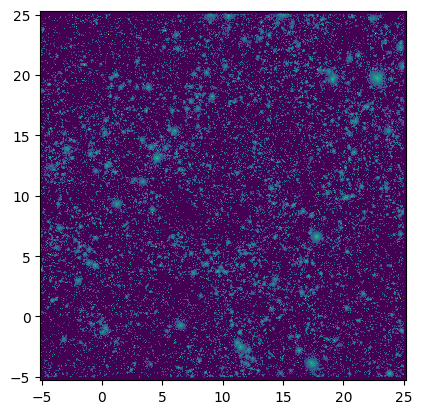

In [4]:
t_all = pd.DataFrame([])
for p in phlists:
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/"+p, hdu=2)
    t_all = vstack([t_all, t])
    
plt.hist2d(t_all["RA"], t_all["DEC"], bins=2000, norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

### Binning clusters:

In [5]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Catalogue of galaxies:

In [6]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


## Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
17964,83,0.362858,0.386705,0.992546,0.007788,2.471400e+14,0.119892,0.119569,1.200570e+14,632.238,4.273180e+12,1.064140e+13,2.30589,0.487051,0.000002,1.864380e+14,993.667,0


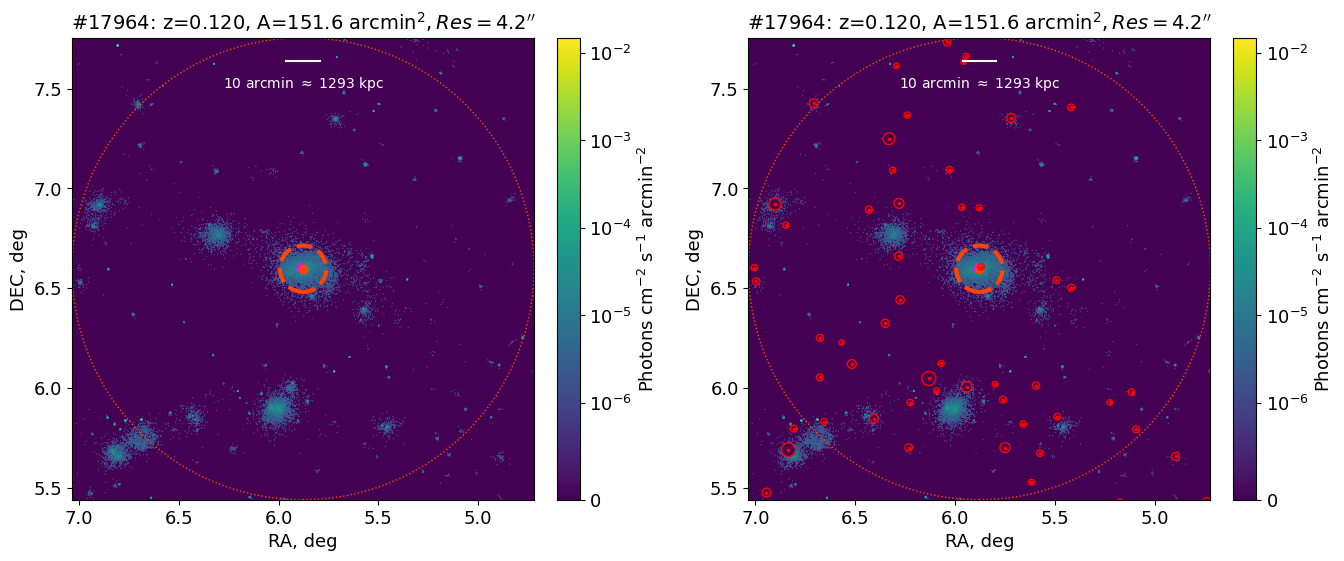

In [6]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))
plt.tight_layout()

cl_num = 17964

display(clusters[clusters.index==cl_num])

plt.subplot(121)
pho_hist1 = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

plt.subplot(122)
pho_hist2, msk = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=True, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

#print(sum(pho_hist1.flatten()), sum(pho_hist2.flatten()))
#display(plist1, plist2)

plt.show()

## Drawing panels:

In [ ]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('panels.png', format='png', dpi=100, bbox_inches='tight')
plt.close()
plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

#### This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 2000 pixels in length) to obtain the flux in corresponding units.

## Filtering of images

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

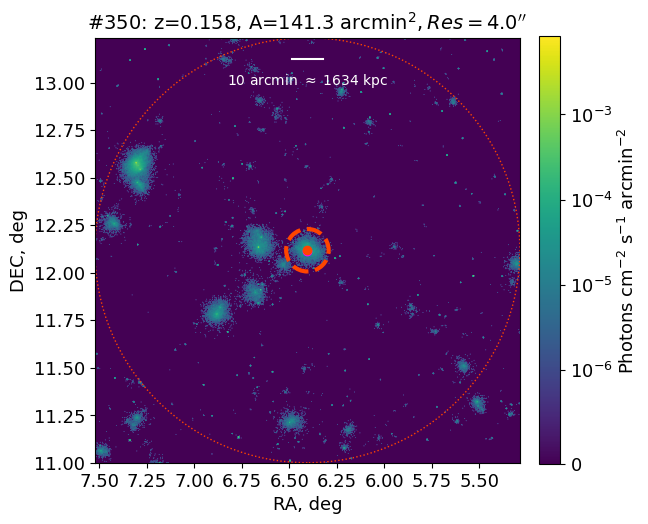

In [58]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001, 
                                     ARF_weights=False)

plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

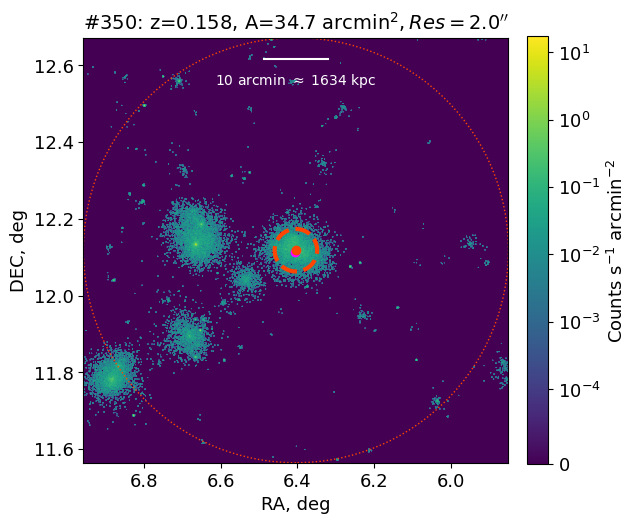

In [79]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty1 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001,
                                     ARF_weights=True)
plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

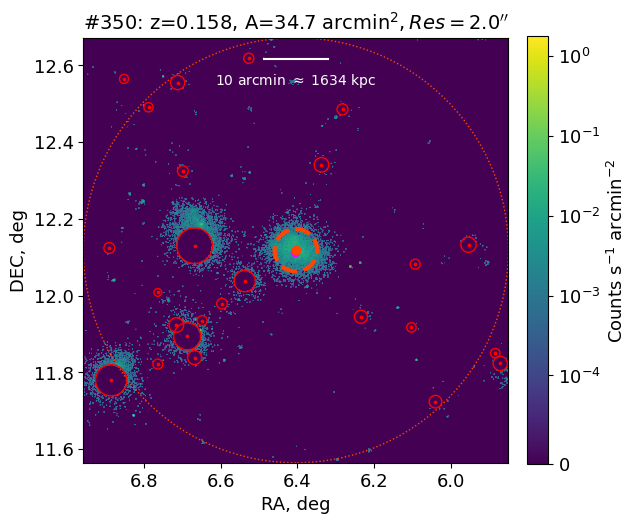

In [52]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty2, msk = extract_photons_from_cluster(cl_num, 
                                          delete_superfluous=True, 
                                          draw=True,
                                          histlen=2001,
                                          ARF_weights=True)
plt.show()

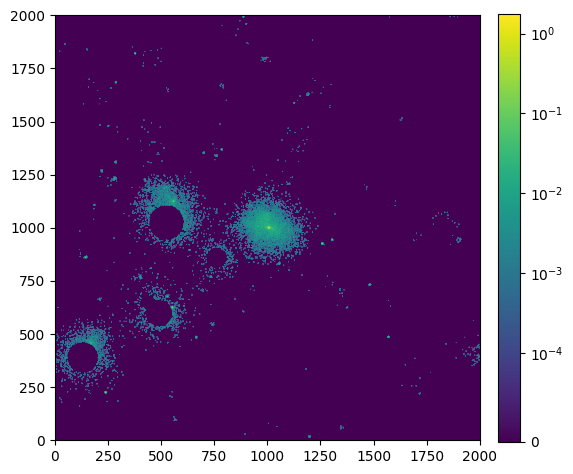

In [53]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(tyty2*(msk))), origin='lower', norm=matplotlib.colors.SymLogNorm(linthresh=0.0001, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

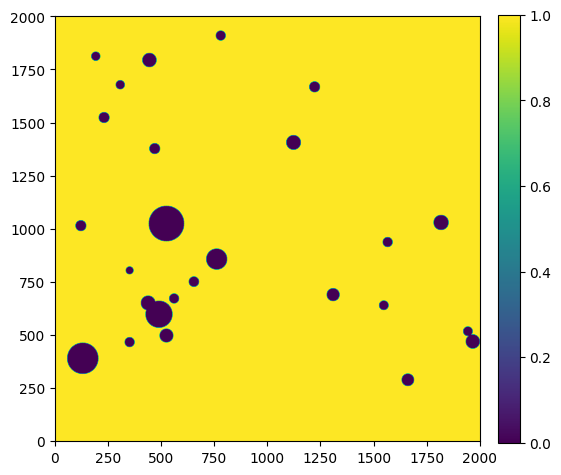

In [54]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(msk)), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

<Figure size 640x480 with 0 Axes>

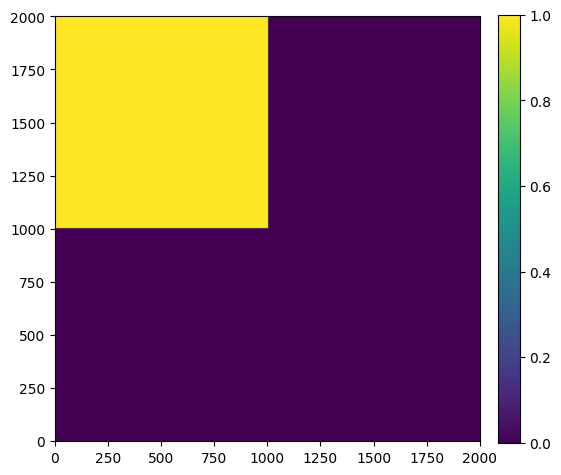

In [55]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(wedge(4, 2001))), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

## Calculating brightness profile for one cluster:

Original:

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


<Figure size 640x480 with 0 Axes>

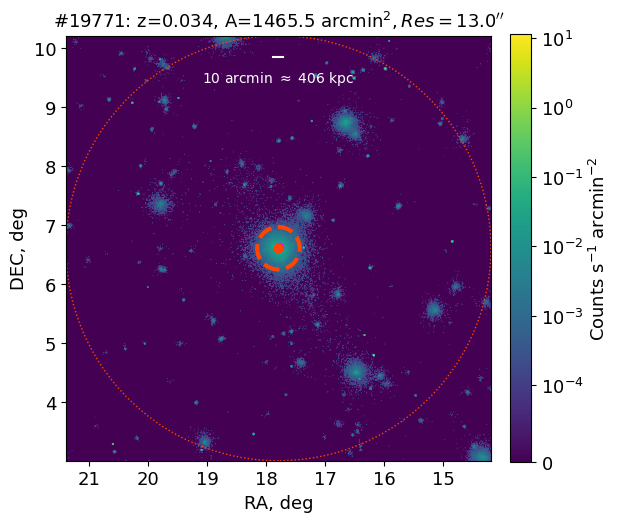

In [93]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 19771

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001, 
                                     ARF_weights=True)

plt.show()

19771
21.597926318745607


  0%|          | 0/24 [00:00<?, ?it/s]

[1.07989632e-01 3.23968895e-01 5.39948158e-01 7.55927421e-01
 9.71906684e-01 1.25355484e+00 1.65672406e+00 2.18956086e+00
 2.89376902e+00 3.82446512e+00 5.05449238e+00 6.68012191e+00
 8.82858759e+00 1.16680444e+01 1.54207293e+01 2.03803555e+01
 2.69351003e+01 3.55979869e+01 4.70470375e+01 6.21783400e+01
 8.21761830e+01 1.08605747e+02 1.43535606e+02 1.89699633e+02]


<Figure size 640x480 with 0 Axes>

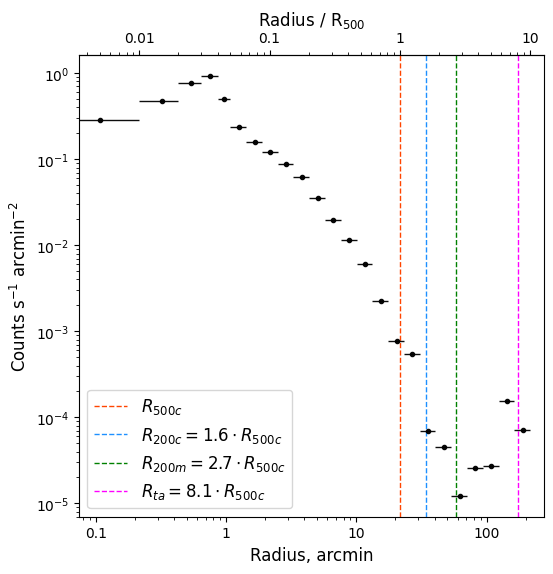

In [103]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=cl_num,
                          hist=tyty0,
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=True,
                          errors=False)

plt.show()

In [104]:
#plt.scatter(rr, np.array(brbr)*140)
#plt.xscale("log")
#plt.yscale("log")

In [105]:
r_pixels_max = 1000

setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
print(setka_bins)
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
print(setka)
err = np.diff(setka_bins)/2
print(err)
print(setka+err)

[   0.            1.            2.            3.            4.
    5.            6.60810365    8.73340676   11.54225142   15.25447874
   20.16063531   26.64471355   35.21420576   46.5398243    61.50799654
   81.29024325  107.43487058  141.98815202  187.65448504  248.0080574
  327.77258973  433.19104912  572.51427033  756.64672756 1000.        ]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.804051823584011, 7.670755204755542, 10.137829089015636, 13.39836507549806, 17.70755702429748, 23.402674430939175, 30.929459652114993, 40.877015026415464, 54.023910416279605, 71.39911989121913, 94.36255691155043, 124.71151129666325, 164.82131852866326, 217.8312712200605, 287.89032356330574, 380.4818194246124, 502.85265972418114, 664.5804989423002, 878.3233637794714]
[  0.5          0.5          0.5          0.5          0.5
   0.80405182   1.06265156   1.40442233   1.85611366   2.45307829
   3.24203912   4.2847461    5.66280927   7.48408612   9.89112336
  13.07231366  17.27664072  22.83316651  30.17678618  39.88226616


In [106]:
r500r=100

print( np.array(setka)/r500r)

[5.00000000e-03 1.50000000e-02 2.50000000e-02 3.50000000e-02
 4.50000000e-02 5.80405182e-02 7.67075520e-02 1.01378291e-01
 1.33983651e-01 1.77075570e-01 2.34026744e-01 3.09294597e-01
 4.08770150e-01 5.40239104e-01 7.13991199e-01 9.43625569e-01
 1.24711511e+00 1.64821319e+00 2.17831271e+00 2.87890324e+00
 3.80481819e+00 5.02852660e+00 6.64580499e+00 8.78323364e+00]


In [110]:
rr = np.array(setka)/r500r*21.597926318745607
dr = np.diff(setka_bins/r500r*21.597926318745607)

print(rr)
print(dr)
print(rr+dr/2)

[1.07989632e-01 3.23968895e-01 5.39948158e-01 7.55927421e-01
 9.71906684e-01 1.25355484e+00 1.65672406e+00 2.18956086e+00
 2.89376902e+00 3.82446512e+00 5.05449238e+00 6.68012191e+00
 8.82858759e+00 1.16680444e+01 1.54207293e+01 2.03803555e+01
 2.69351003e+01 3.55979869e+01 4.70470375e+01 6.21783400e+01
 8.21761830e+01 1.08605747e+02 1.43535606e+02 1.89699633e+02]
[ 0.21597926  0.21597926  0.21597926  0.21597926  0.21597926  0.34731704
  0.4590214   0.6066522   0.80176412  1.05962808  1.40042644  1.85083261
  2.44609875  3.23281481  4.27255507  5.64669735  7.46279227  9.86298096
 13.03512009 17.22748492 22.76820119 30.09092666 39.76879244 52.55926048]
[  0.21597926   0.43195853   0.64793779   0.86391705   1.07989632
   1.42721336   1.88623476   2.49288696   3.29465108   4.35427916
   5.7547056    7.60553821  10.05163696  13.28445177  17.55700684
  23.20370419  30.66649645  40.52947741  53.5645975   70.79208242
  93.56028361 123.65121027 163.42000271 215.97926319]


In [111]:
print(brbr)

[0.2878605141273637, 0.4697651231920557, 0.7655310121663746, 0.9333619511701198, 0.5061676363843127, 0.23459866567905094, 0.15761521768235034, 0.12256551365334559, 0.08867677063704085, 0.06224095520515633, 0.03521965668483944, 0.01953135818274163, 0.01138858375304048, 0.005980028901804701, 0.002268238413599245, 0.0007713916390774337, 0.0005426812019650202, 6.963824765014262e-05, 4.511749802194363e-05, 1.2268778660827468e-05, 2.5743765485432e-05, 2.7058740788740402e-05, 0.00015443660366720526, 7.189400460610216e-05]


In [112]:
D_L = FlatLambdaCDM(H0=100*0.704, Om0=0.272).luminosity_distance(clusters.loc[cl_num]["z_true"]).value # Mpc
N = np.sum(2*np.pi*rr[:16]*dr[:16]*brbr[:16])  # 16th position corresponds to ~R500
print(N)
#N = np.sum(2*np.pi*rr*dr*brbr)
#print(N)
flx = N / 140 * (1.1*1.60218e-9)
print(flx)
L_p = flx * 4 * np.pi * D_L**2 * (3.08e24)**2
print(L_p)
print(clusters.loc[cl_num]["Lx500"],'e+44')

15.273078030430934
1.9226601553339584e-10
5.095615116219007e+44
0.651073 e+44


350
6.707209177086648
4.02231434907745


  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

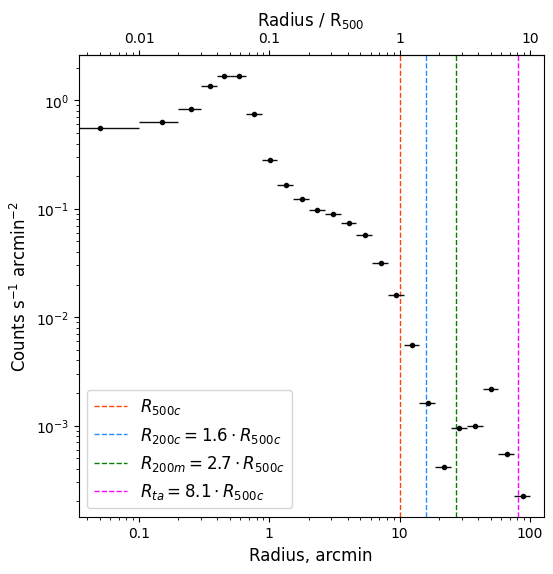

In [80]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=cl_num,
                          hist=np.rot90(tyty1),
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

Filtered:

In [ ]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=np.rot90(np.flip(tyty2)),
                          mmmask=np.rot90(np.flip(msk)),
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

## Calculating profiles for each cluster:

In [ ]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=False,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(clusternumber=cl_num,
                              hist=pho_hist,
                              mmmask='no',
                              field_length=20,
                              draw=False,
                              ARF_weights=True,
                              errors=False)
    
    df_add = pd.DataFrame(brbr).T
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-original.csv', sep=' ', header=False, index=True)

In [117]:
yarkosti = pd.read_csv("brpr-original.csv", sep='\s+', header=None, index_col=0)
yarkosti.index=np.array(clusters.index[:])
display(yarkosti)
#yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
171,0.786480,1.012733,0.894602,0.501962,0.224409,0.157121,0.095383,0.063539,0.039638,0.026682,...,0.001545,0.000478,0.000087,0.000028,0.000053,0.000137,0.000095,0.000253,0.000451,0.000174
187,0.037719,0.021149,0.036419,0.035118,0.025050,0.024056,0.045383,0.036909,0.115743,0.050179,...,0.002861,0.000955,0.000166,0.000481,0.001173,0.002603,0.000360,0.000320,0.000101,0.000854
350,0.312688,0.482869,0.672970,0.616287,0.215940,0.118617,0.072511,0.051164,0.046607,0.039907,...,0.001454,0.000353,0.000526,0.000229,0.001374,0.000442,0.000092,0.000261,0.000048,0.000598
820,0.104093,0.117557,0.112743,0.086098,0.087416,0.116222,0.157224,0.056071,0.034694,0.025034,...,0.001364,0.000439,0.000049,0.000142,0.000014,0.000016,0.000043,0.000074,0.000080,0.000251
1245,0.105534,0.225559,0.402052,0.621450,0.345654,0.111172,0.048693,0.036972,0.023946,0.020401,...,0.001212,0.000563,0.000091,0.000017,0.000086,0.000107,0.000210,0.000078,0.000088,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0.047000,0.063590,0.054344,0.058546,0.043361,0.043674,0.046776,0.042939,0.039969,0.030680,...,0.004395,0.001693,0.000811,0.000319,0.000950,0.000297,0.000073,0.000109,0.000086,0.000213
18610,0.025542,0.025265,0.030184,0.027906,0.028648,0.031108,0.029729,0.032681,0.033741,0.038829,...,0.003052,0.001493,0.000393,0.000127,0.000023,0.000128,0.000051,0.000245,0.000276,0.000144
19523,0.030511,0.022331,0.014232,0.035309,0.055585,0.178931,0.136240,0.027642,0.021510,0.014347,...,0.001847,0.000981,0.000483,0.000157,0.000117,0.000249,0.000009,0.000035,0.000141,0.000141
19771,0.287861,0.469765,0.765531,0.933362,0.506168,0.234599,0.157615,0.122566,0.088677,0.062241,...,0.002268,0.000771,0.000543,0.000070,0.000045,0.000012,0.000026,0.000027,0.000154,0.000072


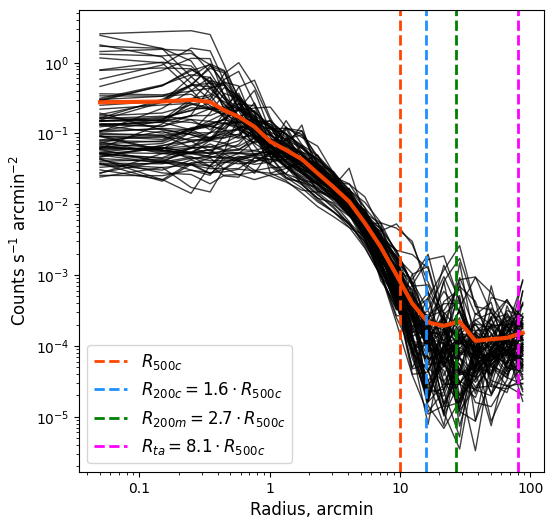

In [115]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[8])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=1
    else:
        llww=1
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)

plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [130]:
table_name =  '0_clean_50_new_new' #_0.5-2.0'
read_table = pd.read_csv('../magneticum/tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))

In [131]:
lumin_usr

[(0.707698, 0.397466354302653, 0.0116393272560811),
 (0.532571, 0.3902937739796141, 0.0092181085514416),
 (1.51569, 0.6576688511193386, 0.0145453103476492),
 (0.972861, 0.445542352151805, 0.0114430276887932),
 (0.452088, 0.2672300201879964, 0.008900028778744),
 (0.566741, 0.3213274599471438, 0.0095914626341578),
 (2.2534, 1.0595337539480358, 0.0179185033578813),
 (3.5805, 1.634385050621601, 0.0218954400076628),
 (0.362044, 0.2167502352440606, 0.009458605228865),
 (25.0979, 2.129101234052904, 0.0296777811231225),
 (0.6138, 0.3958566972635874, 0.0120086638774923),
 (1.85285, 0.7095472291030609, 0.0127002365971791),
 (7.1721, 1.84551346254977, 0.0254317704723968),
 (0.620583, 0.3422620962764418, 0.0103091854866003),
 (7.12626, 1.662936772724942, 0.0239059333602905),
 (1.09336, 0.3912193026892355, 0.0118798390524401),
 (1.62081, 0.4605517126165764, 0.0128548141634396),
 (0.783046, 0.5018132462056568, 0.0128062801064823),
 (0.863919, 0.4531561831291293, 0.0130573390242816),
 (5.39312, 0.831

171
6.006519018523387
0.7505442648719047 cts/s
6.322158552302294e+44
0.707698 e+44
187
5.629821162529902
0.7592245034321052 cts/s
6.4009351733554785e+44
0.532571 e+44
350
6.707209177086648
1.0755755307833517 cts/s
9.152745451669758e+44
1.51569 e+44
820
6.49223189858124
0.7021660269647936 cts/s
6.139463031381513e+44
0.972861 e+44
1245
5.802777110483932
0.49070781944934466 cts/s
4.396420108706217e+44
0.452088 e+44
1380
5.560786551998303
0.6125243303792567 cts/s
5.535605426426388e+44
0.566741 e+44
1707
7.508925770206157
1.257845692024969 cts/s
1.1571418681008152e+45
2.2534 e+44
1819
7.800591264752362
2.0298931460116876 cts/s
1.876955335609784e+45
3.5805 e+44
1838
5.244482925732006
0.43330809080676413 cts/s
4.0101250562416395e+44
0.362044 e+44
2270
8.770062482377352
2.3765050920574042 cts/s
2.2459724926253384e+45
25.0979 e+44
2386
5.284378550918703
0.5803880037993605 cts/s
5.516735758840993e+44
0.6138 e+44
2421
6.585998820114279
1.1333567185905127 cts/s
1.078836787323772e+45
1.85285 e+44
2

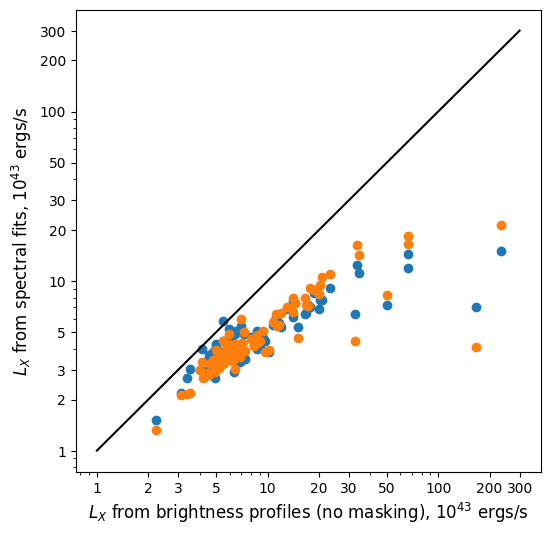

In [174]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]

plt.figure(figsize=(6,6))

lums = []
lums_from_cat = clusters["Lx500"] / E(clusters["z_true"])

for c in clusters.index[:84]:

    print(c)
    cc = clusters.loc[c]
    R_500 = cc["R500"]/0.704  # kpc
    ztrue = cc["z_true"]
    D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(ztrue)*1000 # kpc
    R_500_rescaled = R_500/D_A.value*180/np.pi*60 
    print(R_500_rescaled)
    rr = np.array(setka)/r500r*R_500_rescaled
    dr = np.diff(setka_bins/r500r)*R_500_rescaled
    
    #print(c)
        
    I_x = yarkosti.loc[c].to_numpy()
    #print(I_x)
    I_x = I_x#/factor[c]
    
    D_L = FlatLambdaCDM(H0=100*0.704, Om0=0.272).luminosity_distance(clusters.loc[c]["z_true"]).value # Mpc
    #print(D_L)
    #D_L = 343
    N = np.sum(2*np.pi*rr[:16]*dr[:16]*I_x[:16]) # cts/s
    print(N, 'cts/s')
    flx = N / 140 * (1.1*1.60218e-9) # ergs / s / cm2
    #print(flx)
    lum = flx  * 4*np.pi * D_L**2 * (3.08e24)**2
    print(lum)
    print(cc["Lx500"],'e+44')
    
    lums.append(lum)   # [a[1] for a in lumin_usr]

plt.scatter(lums_from_cat*1e44, np.array(lums)/15)
#plt.scatter(lums_from_cat*1e44, [a[0]*1e44 for a in lumin_usr])
plt.scatter(lums_from_cat*1e44, [a[1]*1e44 for a in lumin_usr])
#plt.scatter(np.array(lums)/15, [a[1]*1e44 for a in lumin_usr])

plt.plot([1e43, 3e45], [1e43, 3e45], color='k')
plt.xlabel("$L_X$ from brightness profiles (no masking), $10^{43}$ ergs/s", fontsize=12)
plt.ylabel("$L_X$ from spectral fits, $10^{43}$ ergs/s", fontsize=12)
plt.xscale("log")
plt.yscale("log")
llll = [1,2,3,5,10,20,30, 50, 100, 200, 300]
plt.xticks(np.array(llll)*1e43, llll)
plt.yticks(np.array(llll)*1e43, llll)
plt.show()

In [153]:
%run -i 'utils/scripts.py'

length = 2001

total_hist_unfiltered = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=False, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist_unfiltered = np.add(total_hist_unfiltered, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

In [155]:
#total_hist_unfiltered140 = total_hist_unfiltered*140

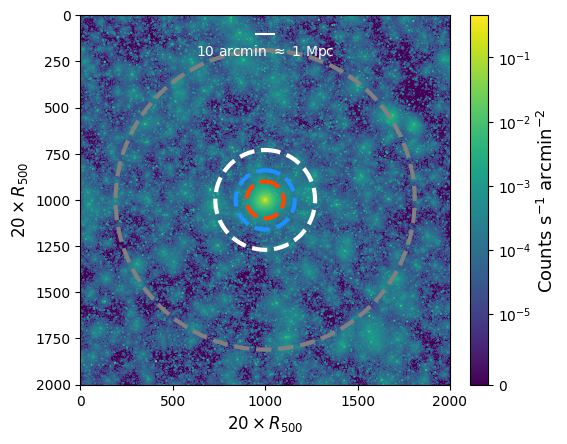

In [156]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist_unfiltered/84), norm=matplotlib.colors.SymLogNorm(linthresh=0.00001, linscale=1), 
           origin='upper')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label(f"Counts s$^{{-1}}$ arcmin$^{{-2}}$", size=13)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

19787
23.302347485770415


  0%|          | 0/24 [00:00<?, ?it/s]

[5.00000000e-02 1.50000000e-01 2.50000000e-01 3.50000000e-01
 4.50000000e-01 5.80405182e-01 7.67075520e-01 1.01378291e+00
 1.33983651e+00 1.77075570e+00 2.34026744e+00 3.09294597e+00
 4.08770150e+00 5.40239104e+00 7.13991199e+00 9.43625569e+00
 1.24711511e+01 1.64821319e+01 2.17831271e+01 2.87890324e+01
 3.80481819e+01 5.02852660e+01 6.64580499e+01 8.78323364e+01]


<Figure size 640x480 with 0 Axes>

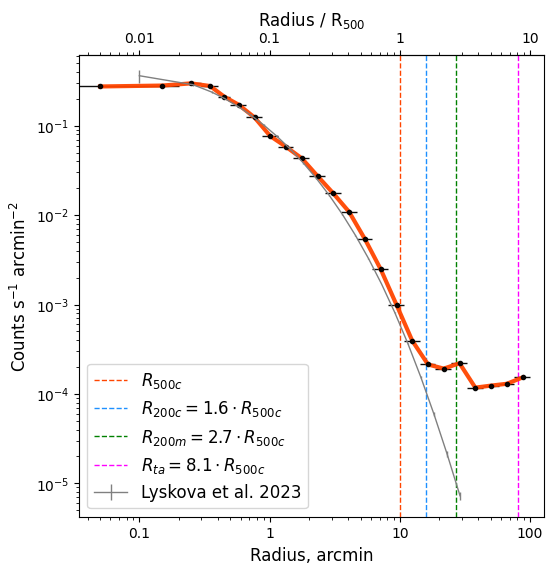

In [165]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=19787,           # choose any
                          hist=total_hist_unfiltered/84,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True)

#plt.ylim(1e-8, 2e1)

plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

plt.errorbar(Ix[0], Ix[1]*3, (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, color='grey', label='Lyskova et al. 2023')

plt.legend(loc=3, fontsize=12)

plt.show()

## And now the same for filtered images:

In [48]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist, mmaasskk = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=True,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(clusternumber=cl_num,
                              hist=pho_hist,
                              mmmask=mmaasskk,
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-masked.csv', sep=' ', header=False, index=True)

  0%|          | 0/84 [00:00<?, ?it/s]

171
6.006519018523387
3.6021103559360643


  0%|          | 0/24 [00:00<?, ?it/s]

187
5.629821162529902
3.376204595220331


  0%|          | 0/24 [00:00<?, ?it/s]

350
6.707209177086648
4.02231434907745


  0%|          | 0/24 [00:00<?, ?it/s]

820
6.49223189858124
3.89339244292728


  0%|          | 0/24 [00:00<?, ?it/s]

1245
5.802777110483932
3.4799263031387895


  0%|          | 0/24 [00:00<?, ?it/s]

1380
5.560786551998303
3.334804528934515


  0%|          | 0/24 [00:00<?, ?it/s]

1707
7.508925770206157
4.50310391016861


  0%|          | 0/24 [00:00<?, ?it/s]

1819
7.800591264752362
4.678015750975929


  0%|          | 0/24 [00:00<?, ?it/s]

1838
5.244482925732006
3.1451171968407836


  0%|          | 0/24 [00:00<?, ?it/s]

2270
8.770062482377352
5.259407785533645


  0%|          | 0/24 [00:00<?, ?it/s]

2386
5.284378550918703
3.1690426092465986


  0%|          | 0/24 [00:00<?, ?it/s]

2421
6.585998820114279
3.949624479828653


  0%|          | 0/24 [00:00<?, ?it/s]

2471
7.7989224225451155
4.677014946054042


  0%|          | 0/24 [00:00<?, ?it/s]

2593
5.634353026891297
3.3789223549572993


  0%|          | 0/24 [00:00<?, ?it/s]

2603
8.773031335435672
5.261188207157825


  0%|          | 0/24 [00:00<?, ?it/s]

2815
5.480492523812426
3.2866521881933592


  0%|          | 0/24 [00:00<?, ?it/s]

2904
5.314287774531306
3.186979175131218


  0%|          | 0/24 [00:00<?, ?it/s]

3155
5.550738221438218
3.3287785435911346


  0%|          | 0/24 [00:00<?, ?it/s]

3886
5.543476906916087
3.3244239321835605


  0%|          | 0/24 [00:00<?, ?it/s]

3985
6.512037765635324
3.90527002436901


  0%|          | 0/24 [00:00<?, ?it/s]

4613
6.152545405144629
3.6896824018858343


  0%|          | 0/24 [00:00<?, ?it/s]

4967
5.3021493116199725
3.1796997371034315


  0%|          | 0/24 [00:00<?, ?it/s]

5326
5.455528607681085
3.271681323946678


  0%|          | 0/24 [00:00<?, ?it/s]

5443
5.229911566060609
3.1363787502612346


  0%|          | 0/24 [00:00<?, ?it/s]

6001
4.882063271582589
2.9277740759115973


  0%|          | 0/24 [00:00<?, ?it/s]

6496
5.795233133092747
3.4754021787662652


  0%|          | 0/24 [00:00<?, ?it/s]

6529
6.737976235455758
4.040765358594158


  0%|          | 0/24 [00:00<?, ?it/s]

6582
5.152505998125743
3.089958619565663


  0%|          | 0/24 [00:00<?, ?it/s]

6695
7.090996755909169
4.252471817636683


  0%|          | 0/24 [00:00<?, ?it/s]

6740
5.073954807956878
3.0428514590446043


  0%|          | 0/24 [00:00<?, ?it/s]

7191
5.065233259731969
3.0376211452665483


  0%|          | 0/24 [00:00<?, ?it/s]

7308
5.635320896874472
3.3795027867313174


  0%|          | 0/24 [00:00<?, ?it/s]

7364
6.470224133781297
3.88019438307724


  0%|          | 0/24 [00:00<?, ?it/s]

7409
5.6832039656173325
3.408218270235282


  0%|          | 0/24 [00:00<?, ?it/s]

7553
4.799233889509479
2.8781012830641552


  0%|          | 0/24 [00:00<?, ?it/s]

7996
4.643228999130438
2.784545126914805


  0%|          | 0/24 [00:00<?, ?it/s]

8211
5.1905778484398715
3.1127903139069693


  0%|          | 0/24 [00:00<?, ?it/s]

8930
4.632210204389375
2.7779371540565965


  0%|          | 0/24 [00:00<?, ?it/s]

9240
6.9078130215544125
4.142616504680307


  0%|          | 0/24 [00:00<?, ?it/s]

9389
7.2241358385203265
4.3323153454394765


  0%|          | 0/24 [00:00<?, ?it/s]

9636
6.5178889047609365
3.908778953379872


  0%|          | 0/24 [00:00<?, ?it/s]

9836
6.618048716523895
3.968844807510582


  0%|          | 0/24 [00:00<?, ?it/s]

10018
6.668572617183262
3.9991439983108017


  0%|          | 0/24 [00:00<?, ?it/s]

10548
8.310514043481694
4.9838165178301015


  0%|          | 0/24 [00:00<?, ?it/s]

10551
6.797901439044547
4.076702512170643


  0%|          | 0/24 [00:00<?, ?it/s]

10820
6.49875778825794
3.8973060199447915


  0%|          | 0/24 [00:00<?, ?it/s]

10842
7.188008977639233
4.310650061552763


  0%|          | 0/24 [00:00<?, ?it/s]

10928
6.74478797841644
4.04485036186893


  0%|          | 0/24 [00:00<?, ?it/s]

11141
8.20331972105217
4.919532066598003


  0%|          | 0/24 [00:00<?, ?it/s]

11272
6.531655382278753
3.9170347120112465


  0%|          | 0/24 [00:00<?, ?it/s]

11428
7.737176797370206
4.639986085379434


  0%|          | 0/24 [00:00<?, ?it/s]

11468
6.310233663252128
3.7842480739143194


  0%|          | 0/24 [00:00<?, ?it/s]

11599
6.43668189815011
3.8600790993403957


  0%|          | 0/24 [00:00<?, ?it/s]

11847
6.994199382335609
4.194422418192269


  0%|          | 0/24 [00:00<?, ?it/s]

12045
7.432307512942886
4.457155929800831


  0%|          | 0/24 [00:00<?, ?it/s]

12296
7.807318993355617
4.682050370827955


  0%|          | 0/24 [00:00<?, ?it/s]

13334
5.816288824199166
3.4880292798795596


  0%|          | 0/24 [00:00<?, ?it/s]

13675
6.101331239727711
3.658969259207023


  0%|          | 0/24 [00:00<?, ?it/s]

13751
5.55365267735628
3.3305263432421466


  0%|          | 0/24 [00:00<?, ?it/s]

14038
5.702983430976518
3.4200800185766225


  0%|          | 0/24 [00:00<?, ?it/s]

14434
6.681297210015732
4.006774938540168


  0%|          | 0/24 [00:00<?, ?it/s]

14559
5.416999450513393
3.248575382616728


  0%|          | 0/24 [00:00<?, ?it/s]

14660
9.863149698929435
5.9149323531810705


  0%|          | 0/24 [00:00<?, ?it/s]

14667
9.961350283652953
5.973823258562491


  0%|          | 0/24 [00:00<?, ?it/s]

14726
9.32041587249455
5.589454796098681


  0%|          | 0/24 [00:00<?, ?it/s]

14857
11.415163162873815
6.845675060194193


  0%|          | 0/24 [00:00<?, ?it/s]

14936
9.056615579149915
5.431253720629634


  0%|          | 0/24 [00:00<?, ?it/s]

15138
8.52407389693125
5.1118883939617685


  0%|          | 0/24 [00:00<?, ?it/s]

16666
7.345007999502431
4.404802398502208


  0%|          | 0/24 [00:00<?, ?it/s]

17017
7.430352691609619
4.455983623154194


  0%|          | 0/24 [00:00<?, ?it/s]

17086
7.34131448264421
4.402587395888582


  0%|          | 0/24 [00:00<?, ?it/s]

17174
8.755454187568258
5.250647188946482


  0%|          | 0/24 [00:00<?, ?it/s]

17365
7.1215037506025345
4.2707668669280565


  0%|          | 0/24 [00:00<?, ?it/s]

17415
9.332484280967982
5.596692222469554


  0%|          | 0/24 [00:00<?, ?it/s]

17421
8.363258143264268
5.015447162377373


  0%|          | 0/24 [00:00<?, ?it/s]

17638
8.902402682828743
5.338772223585454


  0%|          | 0/24 [00:00<?, ?it/s]

17654
8.267910249391251
4.958267016126687


  0%|          | 0/24 [00:00<?, ?it/s]

17964
6.946639799249004
4.16590092908486


  0%|          | 0/24 [00:00<?, ?it/s]

18073
13.753701209678825
8.248096677468562


  0%|          | 0/24 [00:00<?, ?it/s]

18589
11.907569946043338
7.14097148188506


  0%|          | 0/24 [00:00<?, ?it/s]

18610
12.158131743226216
7.291233429221119


  0%|          | 0/24 [00:00<?, ?it/s]

19523
8.893290132392108
5.3333074257224045


  0%|          | 0/24 [00:00<?, ?it/s]

19771
21.597926318745607
12.952279651421653


  0%|          | 0/24 [00:00<?, ?it/s]

19787
23.302347485770415
13.974421280821838


  0%|          | 0/24 [00:00<?, ?it/s]

In [49]:
display(yarkosti)

array([[2.61641083e-02, 3.36909567e-02, 2.97610342e-02, ...,
        8.41943938e-06, 1.49999402e-05, 5.80133427e-06],
       [7.62317751e-04, 4.27431390e-04, 7.36053814e-04, ...,
        6.47178201e-06, 2.04229382e-06, 1.72604458e-05],
       [3.93850579e-03, 6.08204739e-03, 8.47649470e-03, ...,
        3.28229392e-06, 6.08272189e-07, 7.53832371e-06],
       ...,
       [3.96436523e-04, 2.90161695e-04, 1.84920859e-04, ...,
        4.51156064e-07, 1.83269309e-06, 1.82821049e-06],
       [9.16205139e-05, 1.49517283e-04, 2.43653927e-04, ...,
        8.61228135e-09, 4.91542268e-08, 2.28824911e-08],
       [1.37414758e-05, 1.33633998e-05, 1.22982694e-05, ...,
        9.59500979e-09, 1.78742688e-08, 3.46271451e-08]])

In [7]:
yarkosti = pd.read_csv("brpr-masked.csv", sep='\s+', header=None, index_col=0)
yarkosti.index = np.array(clusters.index[:])
print(len(yarkosti))
#display(yarkosti)
yarkosti_84 = yarkosti.to_numpy()

yarkosti_31 = yarkosti.loc[yarkosti.index.isin(clusters_31.index)]
print(len(yarkosti_31))
#display(yarkosti_31) 
yarkosti_31 = yarkosti_31.to_numpy()

84
31


In [9]:
num1 = np.array(yar)/31
num1

array([4.57267544e-03, 4.78839177e-03, 5.69857407e-03, 5.04356821e-03,
       3.98392625e-03, 3.44325372e-03, 2.29287017e-03, 1.51689902e-03,
       1.24345476e-03, 9.31021393e-04, 5.87603794e-04, 3.92404944e-04,
       2.32255581e-04, 1.16193253e-04, 4.78158193e-05, 1.74292107e-05,
       5.44514603e-06, 3.24664142e-06, 2.58323287e-06, 2.12144553e-06,
       1.62558944e-06, 1.18737752e-06, 1.53338179e-06, 1.72175134e-06])

In [11]:
num2 = np.array(yar)/84
num1, num2

(array([4.57267544e-03, 4.78839177e-03, 5.69857407e-03, 5.04356821e-03,
        3.98392625e-03, 3.44325372e-03, 2.29287017e-03, 1.51689902e-03,
        1.24345476e-03, 9.31021393e-04, 5.87603794e-04, 3.92404944e-04,
        2.32255581e-04, 1.16193253e-04, 4.78158193e-05, 1.74292107e-05,
        5.44514603e-06, 3.24664142e-06, 2.58323287e-06, 2.12144553e-06,
        1.62558944e-06, 1.18737752e-06, 1.53338179e-06, 1.72175134e-06]),
 array([1.57680307e-02, 1.60937961e-02, 1.58084938e-02, 1.26269280e-02,
        9.06575997e-03, 6.84341215e-03, 4.78060977e-03, 2.80298013e-03,
        2.06340156e-03, 1.54687248e-03, 9.71842267e-04, 6.26842277e-04,
        3.81827824e-04, 1.90121527e-04, 8.51039166e-05, 3.31221770e-05,
        1.04128228e-05, 6.59255488e-06, 5.85490164e-06, 4.83275899e-06,
        3.25742722e-06, 2.86345491e-06, 3.39691280e-06, 3.17890285e-06]))

<Figure size 640x480 with 0 Axes>

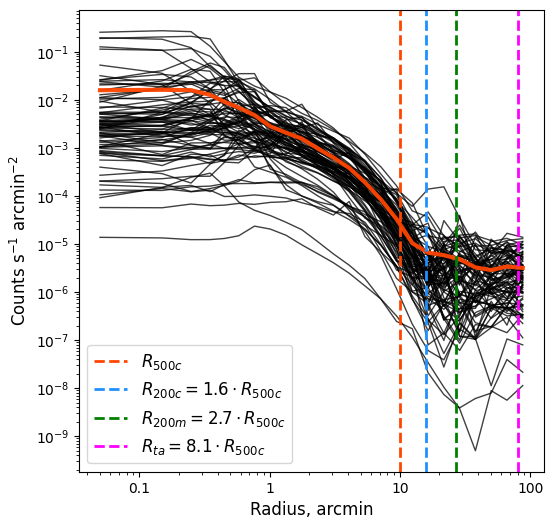

In [10]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti_84[0])*0

for i in range(0, len(yarkosti_84[::])):

    one = yarkosti_84[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
    
    yar = yar + one
    
    if one[-1]==np.nan:
        llww=10
        
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [12]:
%run -i 'utils/scripts.py'

length = 2001

total_hist_masked = np.zeros((length, length))
total_mask = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist, mskk = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=True, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist_masked = np.add(total_hist_masked, pho_hist*mskk)
    total_mask = np.add(total_mask, mskk)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

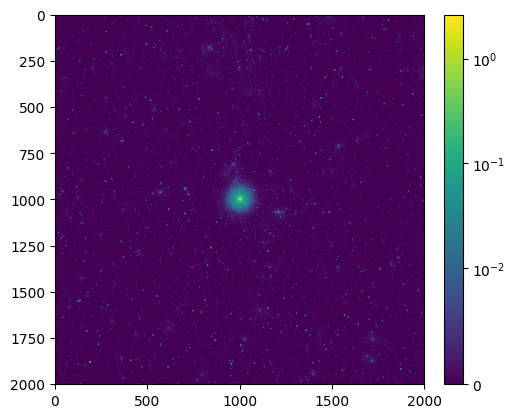

In [13]:
plt.imshow(np.rot90(total_hist_masked), norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

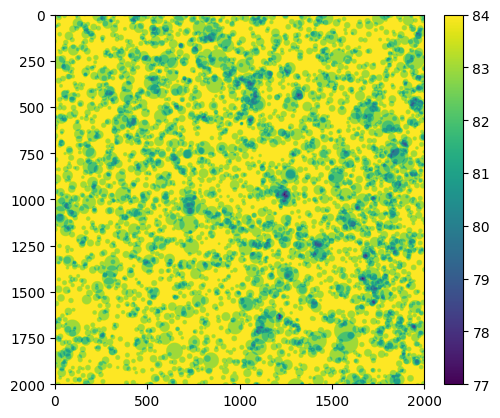

In [14]:
#total_mask[total_mask > 1] = True

plt.imshow(np.rot90(total_mask))
plt.colorbar(fraction=0.046, pad=0.04)

In [15]:
reduced_hist = np.divide(total_hist_masked, total_mask)

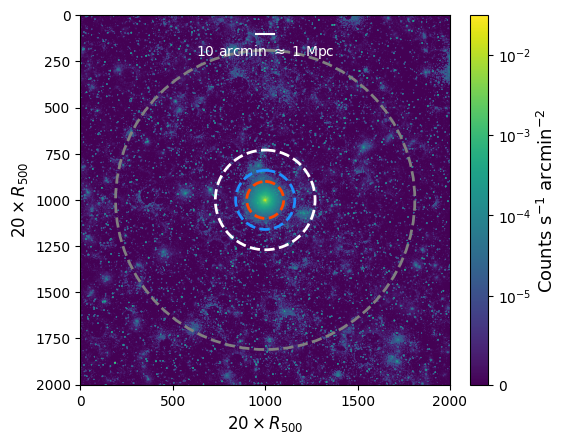

In [16]:
half_length = int(length/2)
r500r = int(half_length/10)

#mask_rescaled = 

plt.imshow(np.rot90(reduced_hist), norm=matplotlib.colors.SymLogNorm(linthresh=0.00001, linscale=1), 
           origin='upper')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label(f"Counts s$^{{-1}}$ arcmin$^{{-2}}$", size=13)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=2, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

19787
23.302347485770415
13.974421280821838


  0%|          | 0/24 [00:00<?, ?it/s]

/home/aleksei/work/clusters/stacking/utils/scripts.py:424: RuntimeWarning: invalid value encountered in scalar divide
  brw2 = (hist*cw).sum()/sum(cw.flatten())


<Figure size 640x480 with 0 Axes>

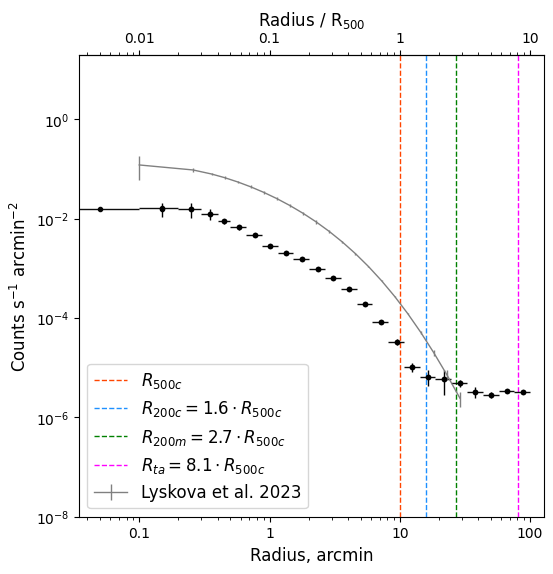

In [29]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=19787,   # choose any
                          hist=reduced_hist,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True,
                          errors=True)

plt.ylim(1e-8, 20)

plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, color='grey', label='Lyskova et al. 2023')
plt.legend(loc=3, fontsize=12)

plt.show()

#### Fitting: simple beta-model

In [30]:
def beta_model_surface_brightness(r, S0, rc, beta):
    
    return S0 * (1 + (r / rc)**2)**(-3 * beta / 2)

In [31]:
true_S0 = 1.0
true_rc = 0.5
true_beta = 2/3

In [32]:
# Fit the beta model to the noisy data
initial_guess = [1.0, 0.5, 0.67]  # Initial guess for S0, rc, beta
popt, pcov = curve_fit(beta_model_surface_brightness, rr, np.array(brbr), p0=initial_guess)

In [33]:
# Extract fitted parameters
fitted_S0, fitted_rc, fitted_beta = popt
print(f"Fitted parameters: S0 = {fitted_S0}, rc = {fitted_rc}, beta = {fitted_beta}")

Fitted parameters: S0 = 0.017172107152232323, rc = 0.6156207500305437, beta = 0.870312904264062


In [34]:
# Generate fitted values for plotting
S_fitted = beta_model_surface_brightness(rr, *popt)
#plt.plot(rr, S_fitted, label='Fitted Beta Model', color='red', ls='--', lw=2)

### Upper and lower borders:

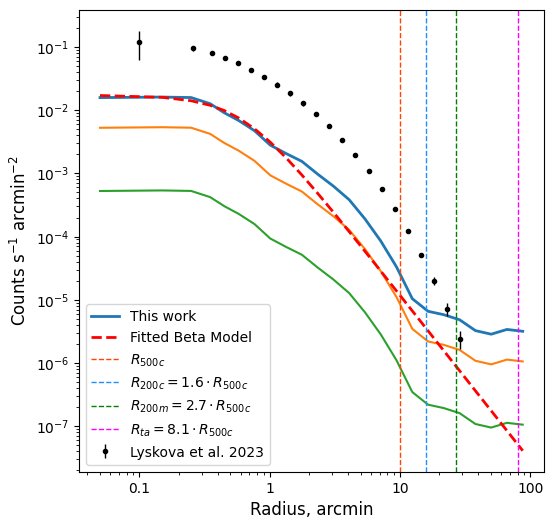

In [35]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)

plt.figure(figsize=(6, 6))

plt.plot(rr, np.array(brbr), label='This work', lw=2)
plt.plot(rr, np.array(brbr)/3.) # np.geomspace(2.3, 0.1*r_pixels_max, 24))
plt.plot(rr, np.array(brbr)/30)
plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=0, elinewidth=1, markersize=3, marker='o', color='black', label='Lyskova et al. 2023')

plt.plot(rr, S_fitted, label='Fitted Beta Model', color='red', ls='--', lw=2)

plt.xlabel("Radius, arcmin", fontsize=12)
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=1)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=1)

plt.legend(loc=3, fontsize=10)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])

plt.show()

## Natalya's data:

In [159]:
Ix = pd.read_csv("natalya/sb_fig3_errorbars.dat", sep='\s+', header=None)
display(Ix)
#yarkosti = yarkosti.to_numpy()

,0,1,2,3
0,0.100019,0.120754,0.061235,0.180273
1,0.258809,0.095725,0.087513,0.103937
2,0.358865,0.079372,0.074380,0.084363
3,0.452170,0.067034,0.062723,0.071345
4,0.569734,0.054965,0.051957,0.057972
5,0.717865,0.043767,0.040844,0.046690
6,0.904510,0.033826,0.031296,0.036357
7,1.139680,0.025341,0.023278,0.027405
8,1.436000,0.018363,0.016830,0.019895
9,1.809360,0.012834,0.011799,0.013868


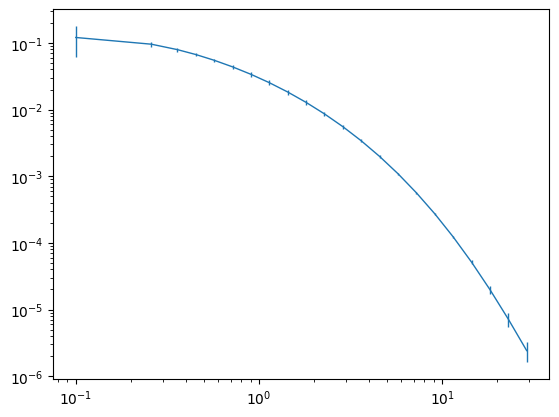

In [160]:
plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1)
plt.xscale("log")
plt.yscale("log")

In [19]:
SMPL = pd.read_csv("sample.dat", sep='\s+', header=0)
display(SMPL)

,Name,M500c(10^14*M_sun),R500c(kpc),z
0,G028.89+60.13,4.47,1133.8,0.1530
1,G031.93+78.71,2.72,973.8,0.0724
2,G033.81+77.18,4.46,1150.2,0.0622
3,G040.03+74.95,2.34,927.8,0.0612
4,G040.58+77.12,2.57,955.2,0.0748
5,G041.45+29.10,5.41,1203.1,0.1780
6,G042.81+56.61,4.22,1127.4,0.0723
7,G044.20+48.66,8.77,1434.7,0.0894
8,G046.88+56.48,5.10,1192.5,0.1145
9,G048.10+57.16,3.54,1062.3,0.0777


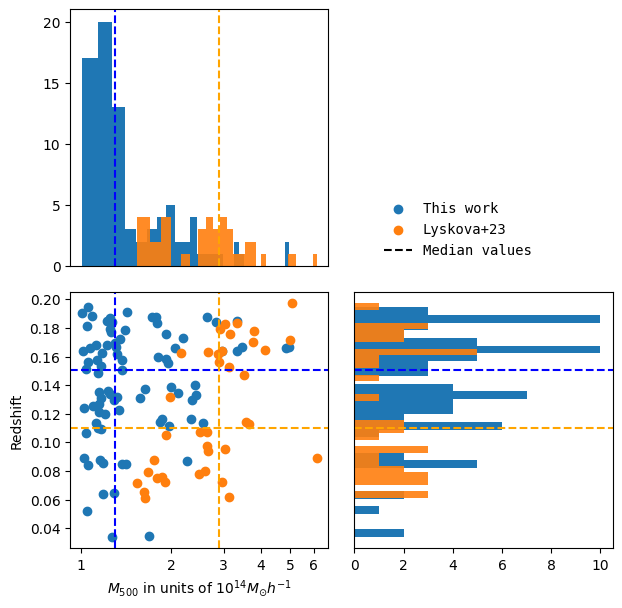

In [20]:
plt.figure(figsize = (7,7))

plt.subplot(221)

plt.hist(clusters["M500"]/10**14, bins=30, histtype='stepfilled')
plt.hist(SMPL["M500c(10^14*M_sun)"]*0.7, bins=30, histtype='stepfilled', alpha=0.9)
#plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
#plt.xticks([])
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='blue')
plt.axvline(np.median(SMPL["M500c(10^14*M_sun)"]*0.704), linestyle='--', color='orange')
plt.xscale("log")
#plt.xticks([1,2,3,4,5], [1,2,3,4,5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks([0,5,10,15,20], [0,5,10,15,20])

plt.subplot(224)

plt.hist(clusters["z_true"], bins=30, histtype='stepfilled', orientation="horizontal")
plt.hist(SMPL["z"], bins=30, histtype='stepfilled', orientation="horizontal", alpha=0.9)
#plt.xlabel("Redshift $z_{true}$")
plt.yticks([])
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='blue')
plt.axhline(np.median(SMPL["z"]), linestyle='--', color='orange')

plt.subplot(223)

plt.scatter(clusters["M500"]/10**14, clusters["z_true"], label='This work')
plt.scatter(SMPL["M500c(10^14*M_sun)"]*0.7, SMPL["z"], label='Lyskova+23')
plt.ylabel("Redshift")
plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.xscale("log")
plt.xticks([1,2,3,4,5,6], [1,2,3,4,5,6])
#plt.yscale("log")
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='blue')
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='blue')
plt.axvline(np.median(SMPL["M500c(10^14*M_sun)"]*0.704), linestyle='--', color='orange')
plt.axhline(np.median(SMPL["z"]), linestyle='--', color='orange')
plt.plot([], [], linestyle='--', color='black', label="Median values")

plt.legend(fontsize=15, prop={'family': 'monospace'},
           frameon=False,
           loc='upper center', bbox_to_anchor=(1.5, 1.4),
           fancybox=True, shadow=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('figures/histogram_84.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [70]:
min(SMPL["M500c(10^14*M_sun)"]*0.704)

1.5488

In [26]:
MASS4 = pd.read_csv("natalya/1234.dat", sep='\s+', header=0, index_col=0)
display(MASS4)

,Mass,Redshift,"R500,arcmin","R,kpc",filename
#,,,,,
1,5.900000e+14,0.1644,7.33,1241.3,fc10.1_Mass5.9e14_z016.radial
2,3.540000e+14,0.0777,12.04,1062.3,fc10.2_Mass3.5e14_z008.radial
3,4.340000e+14,0.0953,10.69,1133.7,fc10.3_Mass4.3e14_z01.radial
4,8.770000e+14,0.0894,14.33,1434.7,fc10.4_Mass8.8e14_z009.radial


(array([1., 0., 3., 2., 2., 5., 2., 1., 0., 0., 1., 0., 2., 3., 0., 3., 2.,
        3., 5., 3.]),
 array([0.8388288 , 0.84473525, 0.8506417 , 0.85654815, 0.8624546 ,
        0.86836106, 0.87426751, 0.88017396, 0.88608041, 0.89198686,
        0.89789331, 0.90379977, 0.90970622, 0.91561267, 0.92151912,
        0.92742557, 0.93333202, 0.93923848, 0.94514493, 0.95105138,
        0.95695783]),
 <BarContainer object of 20 artists>)

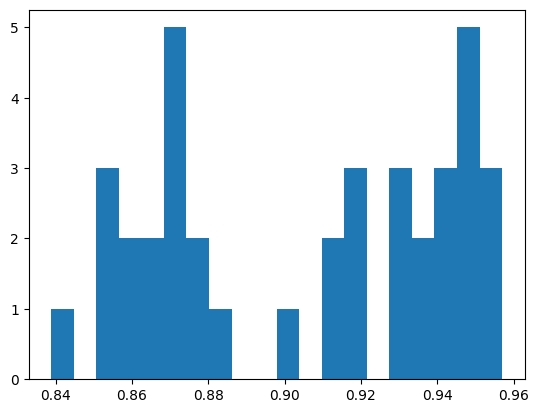

In [27]:
plt.hist(E(SMPL["z"])**(-4)*(1+SMPL["z"]), bins=20)

In [73]:
#bros = [2603, 1707, 11141, 2471]
bros = [2471, 11141, 1707, 2603]
pp = clusters.loc[clusters.index.isin(bros)]
mmm = pp.index
display(pp)
mmm

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0


Index([1707, 2471, 2603, 11141], dtype='int64')

In [74]:
mmm = yarkosti.loc[yarkosti.index.isin(bros)].to_numpy()
mmm

array([[9.72467032e-04, 8.34218428e-04, 9.99250669e-04, 9.86218582e-04,
        9.87169141e-04, 1.00421674e-03, 1.06513022e-03, 9.86852937e-04,
        1.01197049e-03, 9.33479011e-04, 5.61966739e-04, 3.79472802e-04,
        2.41656839e-04, 1.10444874e-04, 4.14136170e-05, 1.06379496e-05,
        1.73813013e-06, 2.63965821e-07, 1.29364053e-07, 3.16930511e-07,
        1.59658964e-06, 8.89811925e-07, 1.37952263e-06, 1.59508304e-06],
       [2.09518408e-03, 2.39842863e-03, 2.53534522e-03, 2.17439699e-03,
        2.04061379e-03, 1.99108179e-03, 2.17130345e-03, 2.24446341e-03,
        1.15449445e-03, 8.39862799e-04, 6.53256233e-04, 2.70344074e-04,
        9.25537679e-05, 3.43663119e-05, 2.33917033e-05, 7.96392388e-06,
        7.26189178e-07, 1.57873919e-07, 5.62322945e-07, 3.75647799e-07,
        5.15728984e-07, 7.24699009e-07, 1.02026448e-06, 3.90701620e-07],
       [3.67020646e-03, 4.07574668e-03, 5.84800416e-03, 5.58587735e-03,
        3.09028851e-03, 2.10694345e-03, 1.34697537e-03, 1.1469

In [81]:
E(0)

1.0

In [21]:
fac1 = 1000/(clusters["R500"]/0.704)
fac2 =  E(clusters["z_true"])**(-4)*(1+clusters["z_true"])**3 
factor = fac1*fac2
fac1[171] #factor

1.023065476190476

749.2054189387177
0.20544064567260073
749.536834058672
0.11294151556544461
753.028839400163
0.07409428632076366
763.3112468408657
0.14468053167195785
772.6707592262335
0.25938271137805086
776.0277737367277
0.22295615107373876
782.9535438154609
0.0888892592466595
784.9586040532548
0.08389588038891141
785.3024144075879
0.3634601742125724
793.5772617933114
0.05100462335889924
795.8628839496164
0.30691208264710423
796.4360971305609
0.11731608175697197
797.5807643398026
0.061380092012220805
800.282047840167
0.16229605896592403
800.4198297419119
0.05358673962384877
805.1172611308913
0.2581800814344427
807.0526404372273
0.28532365615869276
813.1712548650506
0.2101902664326083
829.1719304674058
0.3393578625190665
831.4969294077865
0.15341822191560417
846.5840274611826
0.19048545307566656
854.5238357625049
0.3629590132124734
862.9951548847667
0.2906413374547323
866.0639715318172
0.35937268346621887
878.518142517372
0.48624192571422253
889.8319303665718
0.15225462995994746
890.6708925280633
0.13

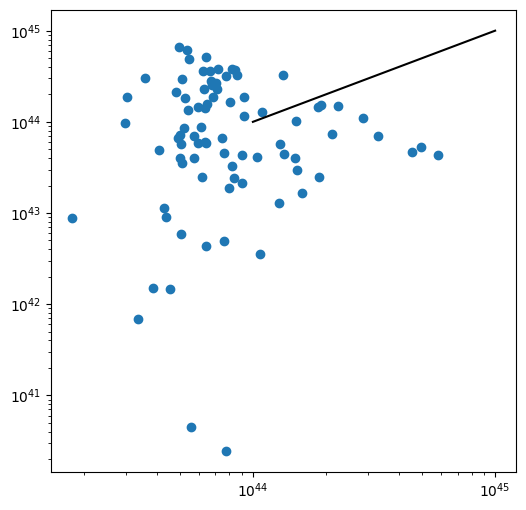

In [24]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)
dr = np.diff(setka_bins/r500r*(10*998/1000))

plt.figure(figsize=(6,6))

lums = []
lums_from_cat = clusters["Lx500"] / E(clusters["z_true"])

for c in clusters.index[:84]:
    #print(c)
        
    I_x = yarkosti.loc[c].to_numpy()
    #print(I_x)
    I_x = I_x/factor[c]
    
    D_L = FlatLambdaCDM(H0=100*0.704, Om0=0.272).luminosity_distance(clusters.loc[c]["z_true"]).value # Mpc
    print(D_L)
    #D_L = 343
    N = np.sum(2*np.pi*rr*dr*I_x) # cts/s
    print(N)
    flx = N / 140 * (1*1.60218e-9) # ergs / s / cm2
    #print(flx)
    lum = flx  * 4*np.pi * D_L**2 * (3.08e24)**2
    
    lums.append(lum)   # [a[1] for a in lumin_usr]

plt.scatter(np.array([a[1] for a in lumin_usr])*1e44, lums)
plt.plot([1e44, 1e45], [1e44, 1e45], color='k')
    
plt.xscale("log")
plt.yscale("log")

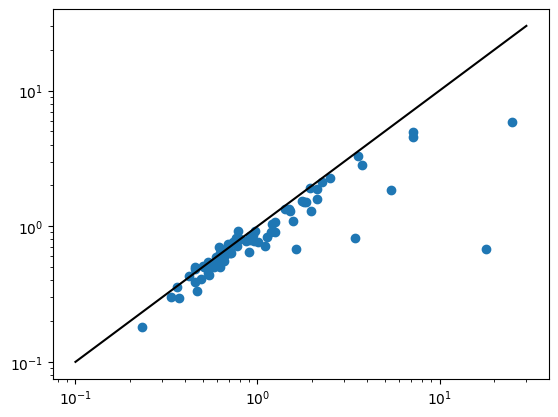

In [23]:
table_name =  '0_clean_50'
read_table = pd.read_csv('../magneticum/tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
#lumin_usr
lum_from_cat = clusters["Lx500"] #/ E(clusters["z_true"])

plt.plot([0.1, 30], [0.1, 30], color='k')
plt.scatter(lum_from_cat, [a[1] for a in lumin_usr])
plt.xscale("log")
plt.yscale("log")
plt.show()

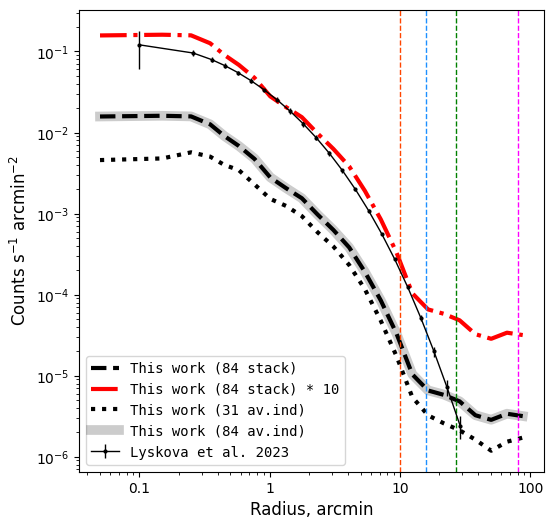

In [44]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)

plt.figure(figsize=(6, 6))

clrs = ['r','g','b','m']

r_sc = [7.33, 12.04, 10.69, 14.33]

#for i in range(1, 5):
#    clname = MASS4["filename"][i]
#    clust = pd.read_csv("natalya/"+clname, sep='\s+', header=None, index_col=None)
#    #display(cl1)
#    plt.errorbar(clust[0]/r_sc[i-1]*10, clust[2]-4e-4, xerr=clust[1]/r_sc[i-1], yerr=clust[3], lw=1, label='m'+MASS4["filename"][i][11:22]+" (L+23)", alpha=0.7, color=clrs[i-1])
    
plt.errorbar(Ix[0], Ix[1], yerr=(Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, elinewidth=1, markersize=2, marker='o', color='black', label='Lyskova et al. 2023')

plt.plot(rr, np.array(brbr), linestyle='--', label='This work (84 stack)', color='black', lw=3)

plt.plot(rr, np.array(brbr)*10, linestyle='-.', label='This work (84 stack) * 10', color='red', lw=3)

plt.plot(rr, np.array(num1), linestyle=':', label='This work (31 av.ind)', color='black', lw=3)

plt.plot(rr, np.array(num2), linestyle='-', label='This work (84 av.ind)', color='black', lw=7, alpha=0.2)

#for i in range(0, 4):
#    plt.plot(rr, np.array(mmm[i]), linestyle=':', color=clrs[i], label='m'+str(clusters.loc[bros[i]]["M500"]/1e14/0.7)+' (TW)', lw=2)

plt.xlabel("Radius, arcmin", fontsize=12)
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

plt.legend(loc=3, fontsize=10, prop={'family': 'monospace'})

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=1)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=1)


plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])

plt.savefig('profiles84-31.pdf')

plt.show()

In [ ]:
clusters.loc[pp[i]]["M500"]/1e14

In [101]:
bros

[2603, 1707, 11141, 2471]

In [37]:
bros = [2603, 1707, 11141, 2471]
pp = clusters.loc[clusters.index.isin(bros)]
mmm = pp.index
display(pp)
mmm

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0


Index([1707, 2471, 2603, 11141], dtype='int64')

In [38]:
display(pp)
pp.loc[bros[2]]

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0


ihal        1.700000e+01
x_pix       4.293381e-01
y_pix       7.725367e-01
z_pix       3.530592e-01
Rrel        7.186739e-03
Mvir        4.513650e+14
z_true      1.329933e-01
z_obs       1.329344e-01
M500        2.425320e+14
R500        8.162590e+02
Mstar500    6.788720e+12
Mgas500     2.558810e+13
T500        3.969120e+00
Lx500       1.763910e+00
Ysz500      6.314628e-06
M200        3.857750e+14
R200        1.293180e+03
flag        0.000000e+00
Name: 11141, dtype: float64

## Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

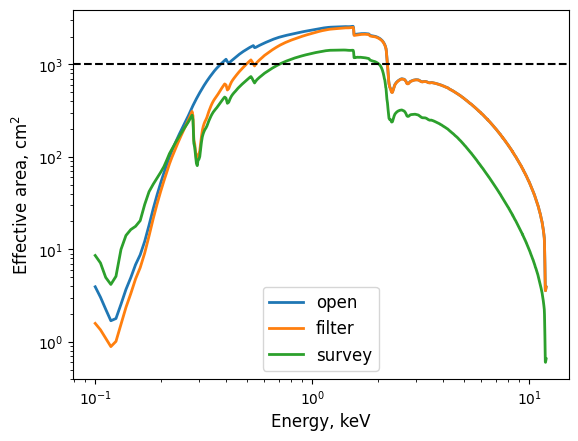

In [51]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

In [61]:
T = Table(arf_survey)[np.where( (arf_survey["ENERG_LO"]>0.3) & (arf_survey["ENERG_HI"]<2.3))]
np.mean(T["SPECRESP"])

137.29648

The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [191]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [193]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014
